In [13]:
import numpy as np

In [14]:
import ccpy

In [15]:
from pyscf import gto, scf

# Testing from PySCF
mol = gto.Mole()
mol.build(
    atom="""F 0.0 0.0 -2.66816
            F 0.0 0.0  2.66816""",
    basis="ccpvdz",
    charge=0,
    spin=0,
    symmetry="D2H",
    cart=True,
    unit='Bohr',
)
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -198.420096282673


-198.42009628267283

In [16]:
from ccpy.interfaces.pyscf_tools import load_pyscf_integrals

nfrozen = 2
system, H = load_pyscf_integrals(mf, nfrozen, dump_integrals=False)

system.print_info()

   System Information:
   ----------------------------------------------------
     Number of correlated electrons = 14
     Number of correlated orbitals = 28
     Number of frozen orbitals = 2
     Number of alpha occupied orbitals = 7
     Number of alpha unoccupied orbitals = 21
     Number of beta occupied orbitals = 7
     Number of beta unoccupied orbitals = 21
     Charge = 0
     Point group = D2h
     Symmetry of reference = AG
     Spin multiplicity of reference = 1

      MO #        Energy (a.u.)      Symmetry    Occupation
-----------------------------------------------------------
         1           -26.443066            AG           2.0
         2           -26.443033           B1U           2.0
         3            -1.597219            AG           2.0
         4            -1.589112           B1U           2.0
         5            -0.725614           B2U           2.0
         6            -0.725614           B3U           2.0
         7            -0.722377      

In [17]:
from ccpy.models.calculation import Calculation
from ccpy.drivers.driver import cc_driver, lcc_driver
from ccpy.hbar.hbar_ccsd import build_hbar_ccsd
from ccpy.moments.crcc23 import calc_crcc23

In [21]:

cc_calc = Calculation(
    order=2,
    calculation_type="ccsd",
    convergence_tolerance=1.0e-08,
)
T, total_energy, is_converged = cc_driver(cc_calc, system, H)

hbar = build_hbar_ccsd(T, H)

lcc_calc = Calculation(
    order=2,
    calculation_type="left_ccsd",
    convergence_tolerance=1.0e-08,
)
L, total_energy, is_converged = lcc_driver(lcc_calc, system, T, hbar)

Ecrcc23, delta23 = calc_crcc23(T, L, hbar, H, system)

   --------------------------------------------------
   Calculation type =  CCSD
   Maximum iterations = 60
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 11:58:00 

   Energy of initial guess =         0.0000000000

                 Iter.         Residuum                 δE                  ΔE               Wall time
-----------------------------------------------------------------------------------------------------
                   0         0.7713827955        -0.5760307223        -0.5760307223          (0.0m 0.1s)
                   1         0.2113849695         0.0049097815        -0.5711209408          (0.0m 0.1s)
                   2         0.0735897040        -0.0237564015        -0.5948773423          (0.0m 0.1s)
                   3         0.0228918927         0.0075473495        -0.5873299928          (0.0m 0.1s)
            

# PES of $\mathrm{F_2^+}$

In [25]:
import numpy as np
import ccpy

from pyscf import gto, scf

from ccpy.interfaces.pyscf_tools import load_pyscf_integrals
from ccpy.models.calculation import Calculation
from ccpy.drivers.driver import cc_driver, lcc_driver
from ccpy.hbar.hbar_ccsd import build_hbar_ccsd
from ccpy.moments.crcc23 import calc_crcc23


In [44]:
def geometry(R):

    f2plus = [['F', (0.0, 0.0, -1.0*R/2)],
              ['F', (0.0, 0.0,  1.0*R/2)]]
    return f2plus

def calc_scf(molecular_geometry):
    mol = gto.Mole()
    mol.build(
        atom = molecular_geometry,
        basis = 'ccpvdz',
        charge = 0,
        spin = 0,
        symmetry = 'D2H',
        cart = True,
        unit = 'Bohr',
    )
    mf = scf.ROHF(mol)
    mf.kernel()
    return mf

ngeoms = 80
R = np.linspace(0.5, 8, ngeoms)

cc_energy = np.zeros(ngeoms)
crcc_energy = np.zeros(ngeoms)

cc_converged = [None] * ngeoms
lcc_converged = [None] * ngeoms


for i in range(len(R)):
    
    # molecular geometry
    geo = geometry(R[i])
    
    # calc hartree-fock
    mf = calc_scf(geo)
    
    # get MO integrals and system object
    nfrozen = 2
    system, H = load_pyscf_integrals(mf, nfrozen, dump_integrals=False)
    
    #CCSD calculation
    cc_calc = Calculation(
        order=2,
        calculation_type="ccsd",
        convergence_tolerance=1.0e-08,
        maximum_iterations=500,
        energy_shift=0.0,
    )
    #if i > 0: # use previous T vector as guess
    #    T, cc_energy[i], cc_converged[i] = cc_driver(cc_calc, system, H, T=T)
    #else:
    
    if R[i] > 5.0:
        T, cc_energy[i], cc_converged[i] = cc_driver(cc_calc, system, H, T=T)
    else:
        T, cc_energy[i], cc_converged[i] = cc_driver(cc_calc, system, H)
        
    # build CCSD HBar
    hbar = build_hbar_ccsd(T, H)
    
    # Left-CCSD calculation
    lcc_calc = Calculation(
        order=2,
        calculation_type="left_ccsd",
        convergence_tolerance=1.0e-08,
        maximum_iterations=80,
    )
    L, _, lcc_converged[i] = lcc_driver(lcc_calc, system, T, hbar)
    
    # Perform CR-CC(2,3) triples correction
    Ecrcc23, delta23 = calc_crcc23(T, L, hbar, H, system)
    crcc_energy[i] = Ecrcc23['D']
    
    

converged SCF energy = -152.362599695869
   --------------------------------------------------
   Calculation type =  CCSD
   Maximum iterations = 500
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 15:48:00 

   Energy of initial guess =         0.0000000000

                 Iter.         Residuum                 δE                  ΔE               Wall time
-----------------------------------------------------------------------------------------------------
                   0         0.2823891120        -0.2396000875        -0.2396000875          (0.0m 0.1s)
                   1         0.0935386864        -0.0313985641        -0.2709986516          (0.0m 0.1s)
                   2         0.0568532734        -0.0088596799        -0.2798583315          (0.0m 0.1s)
                   3         0.0425747773        -0.0044407659        -0.28

                  25         0.0000000082        -0.0000001425         0.0000000136          (0.0m 0.1s)
                  26         0.0000000085         0.0000000006         0.0000000141          (0.0m 0.0s)
   Left CC calculation successfully converged! (0.00m  1.65s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -152.36259970
   CC correlation energy                 0.00000001
   Total CC energy                    -152.36259968

CC calculation ended at 2022-03-05 15:48:32
finished in (0.00m  0.27s)
CCSD = -152.6627620938737
CR-CC(2,3)_A = -152.67902853290886     Ecorr_A = -0.3164288370392866     Delta_A = -0.016266439035145044
CR-CC(2,3)_B = -152.67849154569498     Ecorr_B = -0.31589184982542085     Delta_B = -0.01572945182127929
CR-CC(2,3)_C = -152.68378324460156     Ecorr_C = -0.3211835487320048     Delta_C = -0.021021150727863223
CR-CC(2,3)_D = -152.68362234489635     Ecorr_D = -0.32102264902678107     Delta

                  62         0.0923416433        -0.0056794773        -0.3009659417          (0.0m 0.1s)
                  63         0.0743701343        -0.0044097844        -0.3053757262          (0.0m 0.1s)
                  64         0.0661167812        -0.0034579134        -0.3088336396          (0.0m 0.1s)
                  65         0.0649325976        -0.0027494527        -0.3115830923          (0.0m 0.1s)
   DIIS Cycle - 11
                  66         0.0676465398        -0.0022480215        -0.3138311138          (0.0m 0.1s)
                  67         0.0903172261         0.0137716557        -0.3000594581          (0.0m 0.1s)
                  68         0.0659768456        -0.0058657966        -0.3059252547          (0.0m 0.1s)
                  69         0.0676551350        -0.0042625731        -0.3101878278          (0.0m 0.1s)
                  70         0.0808627658        -0.0030219714        -0.3132097993          (0.0m 0.1s)
                  71         0.09516

                 140         0.0648215311        -0.0050854630        -0.3096931104          (0.0m 0.1s)
                 141         0.0588439761        -0.0035610911        -0.3132542015          (0.0m 0.1s)
                 142         0.0634244655        -0.0024064088        -0.3156606104          (0.0m 0.1s)
                 143         0.0698853748        -0.0015467691        -0.3172073795          (0.0m 0.1s)
   DIIS Cycle - 24
                 144         0.0747555441        -0.0009355679        -0.3181429474          (0.0m 0.1s)
                 145         0.0542963104         0.0105043483        -0.3076385991          (0.0m 0.1s)
                 146         0.0525708995        -0.0032731101        -0.3109117092          (0.0m 0.1s)
                 147         0.0605458123        -0.0021384134        -0.3130501226          (0.0m 0.1s)
                 148         0.0686994504        -0.0013293125        -0.3143794351          (0.0m 0.1s)
                 149         0.07464

   DIIS Cycle - 36
                 216         0.0002187024        -0.0000009463        -0.4086481200          (0.0m 0.2s)
                 217         0.0001624262        -0.0000067532        -0.4086548732          (0.0m 0.1s)
                 218         0.0001637452         0.0000009733        -0.4086539000          (0.0m 0.1s)
                 219         0.0001657874         0.0000012284        -0.4086526716          (0.0m 0.1s)
                 220         0.0001673735         0.0000012984        -0.4086513732          (0.0m 0.1s)
                 221         0.0001683904         0.0000012597        -0.4086501135          (0.0m 0.1s)
   DIIS Cycle - 37
                 222         0.0001690053         0.0000011670        -0.4086489465          (0.0m 0.1s)
                 223         0.0001588502         0.0000067969        -0.4086421496          (0.0m 0.1s)
                 224         0.0001609348        -0.0000005685        -0.4086427181          (0.0m 0.1s)
                 

                 293         0.0000086512         0.0000000364        -0.4086221226          (0.0m 0.1s)
   DIIS Cycle - 49
                 294         0.0000086900         0.0000000328        -0.4086220899          (0.0m 0.1s)
                 295         0.0000080872        -0.0000001048        -0.4086221947          (0.0m 0.1s)
                 296         0.0000081935        -0.0000000014        -0.4086221961          (0.0m 0.1s)
                 297         0.0000083025         0.0000000181        -0.4086221780          (0.0m 0.1s)
                 298         0.0000083923         0.0000000267        -0.4086221513          (0.0m 0.1s)
                 299         0.0000084696         0.0000000296        -0.4086221216          (0.0m 0.1s)
   DIIS Cycle - 50
                 300         0.0000085485         0.0000000294        -0.4086220923          (0.0m 0.1s)
                 301         0.0000077963        -0.0000002633        -0.4086223555          (0.0m 0.1s)
                 

                 370         0.0000077277         0.0000000432        -0.4086223676          (0.0m 0.1s)
                 371         0.0000078505         0.0000000505        -0.4086223171          (0.0m 0.1s)
   DIIS Cycle - 62
                 372         0.0000079424         0.0000000521        -0.4086222650          (0.0m 0.1s)
                 373         0.0000070356        -0.0000001711        -0.4086224361          (0.0m 0.1s)
                 374         0.0000073214        -0.0000000027        -0.4086224388          (0.0m 0.1s)
                 375         0.0000075545         0.0000000271        -0.4086224118          (0.0m 0.1s)
                 376         0.0000077225         0.0000000434        -0.4086223684          (0.0m 0.1s)
                 377         0.0000078391         0.0000000507        -0.4086223177          (0.0m 0.1s)
   DIIS Cycle - 63
                 378         0.0000079212         0.0000000522        -0.4086222654          (0.0m 0.1s)
                 

                 448         0.0000076697         0.0000000403        -0.4086223494          (0.0m 0.1s)
                 449         0.0000077847         0.0000000479        -0.4086223015          (0.0m 0.1s)
   DIIS Cycle - 75
                 450         0.0000078665         0.0000000499        -0.4086222516          (0.0m 0.1s)
                 451         0.0000070024        -0.0000001572        -0.4086224088          (0.0m 0.1s)
                 452         0.0000072818        -0.0000000058        -0.4086224146          (0.0m 0.1s)
                 453         0.0000075114         0.0000000240        -0.4086223906          (0.0m 0.1s)
                 454         0.0000076791         0.0000000405        -0.4086223501          (0.0m 0.1s)
                 455         0.0000077986         0.0000000481        -0.4086223020          (0.0m 0.1s)
   DIIS Cycle - 76
                 456         0.0000078872         0.0000000500        -0.4086222519          (0.0m 0.1s)
                 

                  16         0.0001635964        -0.0000204212         0.0001680879          (0.0m 0.5s)
                  17         0.0001514437        -0.0000124722         0.0001556157          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0001424824        -0.0000091955         0.0001464202          (0.0m 0.1s)
                  19         0.0001046525        -0.0000387867         0.0001076335          (0.0m 0.1s)
                  20         0.0001110911         0.0000066258         0.0001142592          (0.0m 0.1s)
                  21         0.0001198629         0.0000090257         0.0001232849          (0.0m 0.1s)
                  22         0.0001310025         0.0000114615         0.0001347465          (0.0m 0.2s)
                  23         0.0001446388         0.0000140301         0.0001487766          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0001609617         0.0000167943         0.0001655709          (0.0m 0.1s)
                  2

                   1         0.0688703942        -0.0215895896        -0.2894222878          (0.0m 0.2s)
                   2         0.0398681077        -0.0050574915        -0.2944797793          (0.0m 0.1s)
                   3         0.0270452283        -0.0025125502        -0.2969923295          (0.0m 0.2s)
                   4         0.0200745856        -0.0015658928        -0.2985582223          (0.0m 0.1s)
                   5         0.0157947869        -0.0010503119        -0.2996085342          (0.0m 0.2s)
   DIIS Cycle - 1
                   6         0.0128194131        -0.0007334812        -0.3003420153          (0.0m 0.2s)
                   7         0.0005144884        -0.0022532483        -0.3025952636          (0.0m 0.1s)
                   8         0.0004017624        -0.0000047235        -0.3025999871          (0.0m 0.2s)
                   9         0.0003264722        -0.0000034190        -0.3026034061          (0.0m 0.1s)
                  10         0.000271

                   9         0.0000256080        -0.0000001588        -0.2993192131          (0.0m 0.2s)
                  10         0.0000176845        -0.0000001088        -0.2993193219          (0.0m 0.1s)
                  11         0.0000122998        -0.0000000821        -0.2993194040          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000085808        -0.0000000646        -0.2993194686          (0.0m 0.1s)
                  13         0.0000000777        -0.0000001882        -0.2993196568          (0.0m 0.1s)
                  14         0.0000000478         0.0000000015        -0.2993196553          (0.0m 0.2s)
                  15         0.0000000303         0.0000000008        -0.2993196544          (0.0m 0.1s)
                  16         0.0000000196         0.0000000005        -0.2993196540          (0.0m 0.1s)
                  17         0.0000000129         0.0000000003        -0.2993196537          (0.0m 0.3s)
                  18         0.000000

                  10         0.0000003636        -0.0000010249         0.0000012557          (0.0m 0.1s)
                  11         0.0000002040        -0.0000005513         0.0000007044          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000001161        -0.0000003034         0.0000004010          (0.0m 0.1s)
                  13         0.0000000006        -0.0000003991         0.0000000019          (0.0m 0.1s)
                  14         0.0000000002        -0.0000000011         0.0000000009          (0.0m 0.1s)
   Left CC calculation successfully converged! (0.00m  1.20s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -187.96462316
   CC correlation energy                 0.00000000
   Total CC energy                    -187.96462316

CC calculation ended at 2022-03-05 15:49:55
finished in (0.00m  0.39s)
CCSD = -188.26963118683446
CR-CC(2,3)_A = -188.2728356442067     Ecorr_A = -0.308212483

                   9         0.0000004521         0.0000000011        -0.3192232842          (0.0m 0.1s)
                  10         0.0000001989        -0.0000000003        -0.3192232845          (0.0m 0.1s)
                  11         0.0000000893        -0.0000000005        -0.3192232850          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000000406        -0.0000000004        -0.3192232854          (0.0m 0.1s)
                  13         0.0000000001        -0.0000000005        -0.3192232859          (0.0m 0.1s)
   CC calculation successfully converged! (0.00m  2.12s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -193.27148318
   CC correlation energy                -0.31922329
   Total CC energy                    -193.59070647

CC calculation ended at 2022-03-05 15:50:03
   --------------------------------------------------
   Calculation type =  LEFT_CCSD
   Maximum iterations = 80
   Co

                  12         0.0000000072        -0.0000000313         0.0000000250          (0.0m 0.1s)
                  13         0.0000000000        -0.0000000250         0.0000000000          (0.0m 0.1s)
                  14         0.0000000000        -0.0000000000         0.0000000000          (0.0m 0.2s)
   Left CC calculation successfully converged! (0.00m  1.19s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -194.82290189
   CC correlation energy                 0.00000000
   Total CC energy                    -194.82290189

CC calculation ended at 2022-03-05 15:50:09
finished in (0.00m  0.43s)
CCSD = -195.1483465504459
CR-CC(2,3)_A = -195.15126488675554     Ecorr_A = -0.328363001210209     Delta_A = -0.002918336309634233
CR-CC(2,3)_B = -195.15119489229625     Ecorr_B = -0.3282930067509371     Delta_B = -0.0028483418503623247
CR-CC(2,3)_C = -195.15176725487086     Ecorr_C = -0.3288653693255335     Delta_

                  10         0.0000000548        -0.0000000019        -0.3360917205          (0.0m 0.1s)
                  11         0.0000000208        -0.0000000007        -0.3360917212          (0.0m 0.1s)
                  12         0.0000000079        -0.0000000003        -0.3360917215          (0.0m 0.1s)
   CC calculation successfully converged! (0.00m  1.69s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -196.72611130
   CC correlation energy                -0.33609172
   Total CC energy                    -197.06220303

CC calculation ended at 2022-03-05 15:50:17
   --------------------------------------------------
   Calculation type =  LEFT_CCSD
   Maximum iterations = 80
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 15:50:00 

   Energy of initial guess =  

converged SCF energy = -197.710795065134
   --------------------------------------------------
   Calculation type =  CCSD
   Maximum iterations = 500
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 15:50:00 

   Energy of initial guess =         0.0000000000

                 Iter.         Residuum                 δE                  ΔE               Wall time
-----------------------------------------------------------------------------------------------------
                   0         0.2861202261        -0.3181575409        -0.3181575409          (0.0m 0.1s)
                   1         0.0351864175        -0.0247356721        -0.3428932130          (0.0m 0.1s)
                   2         0.0083645847        -0.0022370640        -0.3451302770          (0.0m 0.1s)
                   3         0.0022233134        -0.0003046443        -0.34

                   3         0.0002922255        -0.0023406016         0.0009546982          (0.0m 0.1s)
                   4         0.0000997539        -0.0006288023         0.0003258959          (0.0m 0.1s)
                   5         0.0000359122        -0.0002085706         0.0001173253          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0000134416        -0.0000734114         0.0000439138          (0.0m 0.2s)
                   7         0.0000002475        -0.0000431051         0.0000008087          (0.0m 0.4s)
                   8         0.0000000971        -0.0000004914         0.0000003173          (0.0m 0.1s)
                   9         0.0000000398        -0.0000001874         0.0000001299          (0.0m 0.1s)
                  10         0.0000000165        -0.0000000759         0.0000000540          (0.0m 0.1s)
                  11         0.0000000069        -0.0000000314         0.0000000226          (0.0m 0.1s)
   DIIS Cycle - 2
                  1

                   2         0.0094803157        -0.0025015966        -0.3590534689          (0.0m 0.1s)
                   3         0.0025386696        -0.0003525496        -0.3594060185          (0.0m 0.2s)
                   4         0.0007749162        -0.0000831428        -0.3594891613          (0.0m 0.1s)
                   5         0.0002675859        -0.0000261948        -0.3595153561          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0001003675        -0.0000092477        -0.3595246038          (0.0m 0.1s)
                   7         0.0000023473        -0.0000055019        -0.3595301057          (0.0m 0.1s)
                   8         0.0000009367         0.0000000171        -0.3595300885          (0.0m 0.1s)
                   9         0.0000003948         0.0000000073        -0.3595300813          (0.0m 0.1s)
                  10         0.0000001712         0.0000000020        -0.3595300793          (0.0m 0.1s)
                  11         0.000000

                   7         0.0000008269        -0.0000753129         0.0000025733          (0.0m 0.1s)
                   8         0.0000004004        -0.0000013274         0.0000012459          (0.0m 0.1s)
                   9         0.0000002013        -0.0000006196         0.0000006263          (0.0m 0.1s)
                  10         0.0000001025        -0.0000003073         0.0000003190          (0.0m 0.1s)
                  11         0.0000000526        -0.0000001554         0.0000001636          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000000271        -0.0000000794         0.0000000843          (0.0m 0.1s)
                  13         0.0000000001        -0.0000000841         0.0000000002          (0.0m 0.1s)
                  14         0.0000000000        -0.0000000001         0.0000000001          (0.0m 0.1s)
   Left CC calculation successfully converged! (0.00m  0.89s)

   CC Calculation Summary
  --------------------------------------------------


                   5         0.0005669876        -0.0000478678        -0.3745400078          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0002718271        -0.0000192797        -0.3745592875          (0.0m 0.1s)
                   7         0.0000087371        -0.0000149705        -0.3745742580          (0.0m 0.1s)
                   8         0.0000038854         0.0000001202        -0.3745741378          (0.0m 0.1s)
                   9         0.0000018716         0.0000000571        -0.3745740807          (0.0m 0.1s)
                  10         0.0000009448         0.0000000198        -0.3745740609          (0.0m 0.1s)
                  11         0.0000004902         0.0000000062        -0.3745740547          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000002590         0.0000000014        -0.3745740533          (0.0m 0.1s)
                  13         0.0000000007        -0.0000000013        -0.3745740546          (0.0m 0.1s)
   CC calculation s

                  11         0.0000004612        -0.0000008525         0.0000013587          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000002844        -0.0000005208         0.0000008379          (0.0m 0.1s)
                  13         0.0000000011        -0.0000008348         0.0000000031          (0.0m 0.1s)
                  14         0.0000000005        -0.0000000017         0.0000000014          (0.0m 0.1s)
   Left CC calculation successfully converged! (0.00m  0.97s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.64977444
   CC correlation energy                 0.00000000
   Total CC energy                    -198.64977444

CC calculation ended at 2022-03-05 15:50:53
finished in (0.00m  0.30s)
CCSD = -199.02962968766343
CR-CC(2,3)_A = -199.03454006034815     Ecorr_A = -0.38476561693516614     Delta_A = -0.004910372684701963
CR-CC(2,3)_B = -199.03437539713528     Ecorr_B = -0.3846009

                   9         0.0000075433         0.0000001998        -0.3907475691          (0.0m 0.2s)
                  10         0.0000044241         0.0000000774        -0.3907474918          (0.0m 0.1s)
                  11         0.0000026978         0.0000000259        -0.3907474659          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000016815         0.0000000048        -0.3907474611          (0.0m 0.1s)
                  13         0.0000000078        -0.0000000188        -0.3907474799          (0.0m 0.1s)
                  14         0.0000000027        -0.0000000001        -0.3907474800          (0.0m 0.1s)
   CC calculation successfully converged! (0.00m  2.09s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.68439943
   CC correlation energy                -0.39074748
   Total CC energy                    -199.07514691

CC calculation ended at 2022-03-05 15:51:00
   -----------

                  13         0.0000000136        -0.0000079765         0.0000000378          (0.0m 0.1s)
                  14         0.0000000068        -0.0000000190         0.0000000187          (0.0m 0.1s)
                  15         0.0000000037        -0.0000000085         0.0000000102          (0.0m 0.1s)
   Left CC calculation successfully converged! (0.00m  0.96s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.68961883
   CC correlation energy                 0.00000001
   Total CC energy                    -198.68961881

CC calculation ended at 2022-03-05 15:51:04
finished in (0.00m  0.32s)
CCSD = -199.08596614926395
CR-CC(2,3)_A = -199.09262103224026     Ecorr_A = -0.40300220716400453     Delta_A = -0.006654882976312617
CR-CC(2,3)_B = -199.09233193798065     Ecorr_B = -0.4027131129043898     Delta_B = -0.006365788716697925
CR-CC(2,3)_C = -199.09401283902852     Ecorr_C = -0.4043940139522799     Delt

                   7         0.0000765895        -0.0001064350        -0.4079048964          (0.0m 0.1s)
                   8         0.0000416459         0.0000008494        -0.4079040470          (0.0m 0.1s)
                   9         0.0000263538         0.0000005441        -0.4079035029          (0.0m 0.1s)
                  10         0.0000179396         0.0000002192        -0.4079032836          (0.0m 0.1s)
                  11         0.0000125746         0.0000000701        -0.4079032135          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000089327         0.0000000031        -0.4079032105          (0.0m 0.1s)
                  13         0.0000000449        -0.0000001521        -0.4079033626          (0.0m 0.1s)
                  14         0.0000000173        -0.0000000010        -0.4079033635          (0.0m 0.1s)
                  15         0.0000000078        -0.0000000004        -0.4079033640          (0.0m 0.1s)
   CC calculation successfully conver

                   3         0.0029805250        -0.0062099275         0.0077301895          (0.0m 0.1s)
                   4         0.0017609533        -0.0031601244         0.0045700651          (0.0m 0.1s)
                   5         0.0010688448        -0.0017951767         0.0027748884          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0006565493        -0.0010700216         0.0017048668          (0.0m 0.1s)
                   7         0.0000708078        -0.0015209379         0.0001839289          (0.0m 0.1s)
                   8         0.0000541197        -0.0000433484         0.0001405805          (0.0m 0.1s)
                   9         0.0000419838        -0.0000315239         0.0001090566          (0.0m 0.1s)
                  10         0.0000327335        -0.0000240284         0.0000850282          (0.0m 0.1s)
                  11         0.0000255875        -0.0000185624         0.0000664659          (0.0m 0.1s)
   DIIS Cycle - 2
                  1

                  19         0.0000000004        -0.0000000425         0.0000000010          (0.0m 0.1s)
                  20         0.0000000003        -0.0000000002         0.0000000008          (0.0m 0.1s)
   Left CC calculation successfully converged! (0.00m  1.74s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.66972966
   CC correlation energy                 0.00000000
   Total CC energy                    -198.66972966

CC calculation ended at 2022-03-05 15:51:21
finished in (0.00m  1.02s)
CCSD = -199.08982081653502
CR-CC(2,3)_A = -199.09997444925904     Ecorr_A = -0.43024479095015444     Delta_A = -0.010153632724022877
CR-CC(2,3)_B = -199.09937718213257     Ecorr_B = -0.42964752382369603     Delta_B = -0.00955636559756447
CR-CC(2,3)_C = -199.10217131609656     Ecorr_C = -0.43244165778766513     Delta_C = -0.012350499561533543
CR-CC(2,3)_D = -199.10200984455338     Ecorr_D = -0.43228018624450676     De

                   0         0.3867047657        -0.3890697396        -0.3890697396          (0.0m 0.1s)
                   1         0.0920081627        -0.0343850325        -0.4234547720          (0.0m 0.1s)
                   2         0.0338700640        -0.0059114522        -0.4293662242          (0.0m 0.1s)
                   3         0.0143927677        -0.0019476701        -0.4313138944          (0.0m 0.2s)
                   4         0.0069354859        -0.0008795592        -0.4321934535          (0.0m 0.1s)
                   5         0.0036729816        -0.0004246462        -0.4326180997          (0.0m 0.2s)
   DIIS Cycle - 1
                   6         0.0021661031        -0.0002122791        -0.4328303788          (0.0m 0.1s)
                   7         0.0002163698        -0.0002424002        -0.4330727790          (0.0m 0.1s)
                   8         0.0001434617         0.0000022089        -0.4330705702          (0.0m 0.1s)
                   9         0.000107

                  14         0.0000001697        -0.0000000090        -0.4398652686          (0.0m 0.1s)
                  15         0.0000000828        -0.0000000037        -0.4398652723          (0.0m 0.1s)
                  16         0.0000000427        -0.0000000022        -0.4398652745          (0.0m 0.1s)
                  17         0.0000000238        -0.0000000011        -0.4398652756          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000000146        -0.0000000006        -0.4398652762          (0.0m 0.1s)
                  19         0.0000000022        -0.0000000008        -0.4398652770          (0.0m 0.1s)
   CC calculation successfully converged! (0.00m  2.02s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.63582404
   CC correlation energy                -0.43986528
   Total CC energy                    -199.07568932

CC calculation ended at 2022-03-05 15:51:35
   -----------

                   1         0.0311854749        -0.3598970633         0.0701705548          (0.0m 0.1s)
                   2         0.0121358865        -0.0426458960         0.0275246588          (0.0m 0.1s)
                   3         0.0082066840        -0.0088320786         0.0186925802          (0.0m 0.1s)
                   4         0.0053440624        -0.0064867133         0.0122058668          (0.0m 0.1s)
                   5         0.0035615969        -0.0040569086         0.0081489582          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0023615528        -0.0027395294         0.0054094289          (0.0m 0.1s)
                   7         0.0002644401        -0.0048023474         0.0006070814          (0.0m 0.1s)
                   8         0.0002237062        -0.0000935110         0.0005135705          (0.0m 0.1s)
                   9         0.0001918624        -0.0000731021         0.0004404684          (0.0m 0.1s)
                  10         0.000165

                  16         0.0000000759        -0.0000001417         0.0000001701          (0.0m 0.1s)
                  17         0.0000000433        -0.0000000732         0.0000000969          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000000263        -0.0000000379         0.0000000590          (0.0m 0.1s)
                  19         0.0000000048        -0.0000000482         0.0000000108          (0.0m 0.1s)
                  20         0.0000000040        -0.0000000018         0.0000000090          (0.0m 0.1s)
   Left CC calculation successfully converged! (0.00m  2.59s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.61060135
   CC correlation energy                 0.00000001
   Total CC energy                    -198.61060134

CC calculation ended at 2022-03-05 15:51:48
finished in (0.00m  0.31s)
CCSD = -199.06460459047267
CR-CC(2,3)_A = -199.08101464992112     Ecorr_A = -0.47041329

converged SCF energy = -198.585253818116
   --------------------------------------------------
   Calculation type =  CCSD
   Maximum iterations = 500
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 15:51:00 

   Energy of initial guess =         0.0000000000

                 Iter.         Residuum                 δE                  ΔE               Wall time
-----------------------------------------------------------------------------------------------------
                   0         0.4346125276        -0.4163666368        -0.4163666368          (0.0m 0.4s)
                   1         0.1254468185        -0.0381150696        -0.4544817064          (0.0m 0.1s)
                   2         0.0487227029        -0.0081873064        -0.4626690129          (0.0m 0.2s)
                   3         0.0213879104        -0.0031029974        -0.46

                   3         0.0224671609        -0.0032907249        -0.4731093798          (0.0m 0.1s)
                   4         0.0106993987        -0.0015653855        -0.4746747653          (0.0m 0.1s)
                   5         0.0053915068        -0.0007564416        -0.4754312069          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0029561801        -0.0003751742        -0.4758063810          (0.0m 0.1s)
                   7         0.0005798562        -0.0003986364        -0.4762050174          (0.0m 0.1s)
                   8         0.0004730423         0.0000052483        -0.4761997691          (0.0m 0.1s)
                   9         0.0004044237         0.0000026473        -0.4761971218          (0.0m 0.1s)
                  10         0.0003498701         0.0000010425        -0.4761960793          (0.0m 0.1s)
                  11         0.0003036044         0.0000001961        -0.4761958832          (0.0m 0.1s)
   DIIS Cycle - 2
                  1

                  11         0.0003488795         0.0000001928        -0.4837383607          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0003057428        -0.0000002483        -0.4837386090          (0.0m 0.1s)
                  13         0.0000012823        -0.0000053449        -0.4837439538          (0.0m 0.1s)
                  14         0.0000005668        -0.0000000353        -0.4837439891          (0.0m 0.1s)
                  15         0.0000002799        -0.0000000103        -0.4837439995          (0.0m 0.1s)
                  16         0.0000001389        -0.0000000075        -0.4837440069          (0.0m 0.1s)
                  17         0.0000000735        -0.0000000033        -0.4837440102          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000000418        -0.0000000019        -0.4837440121          (0.0m 0.1s)
                  19         0.0000000119        -0.0000000022        -0.4837440143          (0.0m 0.1s)
                  2

   DIIS Cycle - 3
                  18         0.0000000412        -0.0000000018        -0.4913042656          (0.0m 0.4s)
                  19         0.0000000118        -0.0000000021        -0.4913042677          (0.0m 0.3s)
                  20         0.0000000103         0.0000000000        -0.4913042677          (0.0m 0.2s)
                  21         0.0000000090        -0.0000000000        -0.4913042677          (0.0m 0.1s)
   CC calculation successfully converged! (0.00m  3.15s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.54901209
   CC correlation energy                -0.49130427
   Total CC energy                    -199.04031636

CC calculation ended at 2022-03-05 15:52:15
   --------------------------------------------------
   Calculation type =  LEFT_CCSD
   Maximum iterations = 80
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   ----------

   Energy of initial guess =         0.0000000000

                 Iter.         Residuum                 δE                  ΔE               Wall time
-----------------------------------------------------------------------------------------------------
                   0         0.4210314276         0.7590545702         0.7590545702          (0.0m 0.5s)
                   1         0.0781271423        -0.6145467893         0.1445077809          (0.0m 0.1s)
                   2         0.0319419089        -0.0841024214         0.0604053595          (0.0m 0.1s)
                   3         0.0252630749        -0.0119589587         0.0484464008          (0.0m 0.1s)
                   4         0.0173721369        -0.0148029148         0.0336434860          (0.0m 0.1s)
                   5         0.0123667802        -0.0095301163         0.0241133696          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0086890429        -0.0070901459         0.0170232237          (0.

                   7         0.0005492550        -0.0181337217         0.0010718343          (0.0m 0.1s)
                   8         0.0004506500        -0.0001924186         0.0008794157          (0.0m 0.1s)
                   9         0.0003939541        -0.0001106335         0.0007687822          (0.0m 0.1s)
                  10         0.0003551482        -0.0000757220         0.0006930602          (0.0m 0.1s)
                  11         0.0003248113        -0.0000591957         0.0006338645          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0002990472        -0.0000502730         0.0005835914          (0.0m 0.1s)
                  13         0.0000081116        -0.0005677600         0.0000158315          (0.0m 0.1s)
                  14         0.0000053636        -0.0000053632         0.0000104683          (0.0m 0.1s)
                  15         0.0000036736        -0.0000032984         0.0000071698          (0.0m 0.1s)
                  16         0.000002

                  15         0.0000040789        -0.0000036174         0.0000078529          (0.0m 0.1s)
                  16         0.0000028668        -0.0000023336         0.0000055192          (0.0m 0.1s)
                  17         0.0000020595        -0.0000015541         0.0000039651          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000015174        -0.0000010438         0.0000029213          (0.0m 0.1s)
                  19         0.0000002252        -0.0000024876         0.0000004336          (0.0m 0.1s)
                  20         0.0000001887        -0.0000000703         0.0000003633          (0.0m 0.1s)
                  21         0.0000001686        -0.0000000387         0.0000003246          (0.0m 0.1s)
                  22         0.0000001530        -0.0000000300         0.0000002945          (0.0m 0.1s)
                  23         0.0000001403        -0.0000000244         0.0000002702          (0.0m 0.1s)
   DIIS Cycle - 4
                  2

                  23         0.0000001903        -0.0000000306         0.0000003620          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000001763        -0.0000000266         0.0000003354          (0.0m 0.1s)
                  25         0.0000000128        -0.0000003111         0.0000000243          (0.0m 0.1s)
                  26         0.0000000080        -0.0000000091         0.0000000152          (0.0m 0.1s)
   Left CC calculation successfully converged! (0.00m  3.11s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.50629849
   CC correlation energy                 0.00000002
   Total CC energy                    -198.50629847

CC calculation ended at 2022-03-05 15:52:39
finished in (0.00m  0.31s)
CCSD = -199.02735193147228
CR-CC(2,3)_A = -199.05658557520806     Ecorr_A = -0.5502870873181489     Delta_A = -0.02923364373579312
CR-CC(2,3)_B = -199.0532230825016     Ecorr_B = -0.5469245946

finished in (0.00m  0.43s)
CCSD = -199.02497536386954
CR-CC(2,3)_A = -199.05543348562315     Ecorr_A = -0.5586696765225132     Delta_A = -0.030458121753596315
CR-CC(2,3)_B = -199.05182590069282     Ecorr_B = -0.5550620915921795     Delta_B = -0.026850536823262522
CR-CC(2,3)_C = -199.06172967718237     Ecorr_C = -0.5649658680817524     Delta_C = -0.0367543133128355
CR-CC(2,3)_D = -199.05997047477092     Ecorr_D = -0.5632066656703042     Delta_D = -0.03499511090138727
converged SCF energy = -198.487691724611
   --------------------------------------------------
   Calculation type =  CCSD
   Maximum iterations = 500
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 15:52:00 

   Energy of initial guess =         0.0000000000

                 Iter.         Residuum                 δE                  ΔE               Wall time
---------------------

                   0         0.5809080371        -0.4894419567        -0.4894419567          (0.0m 0.2s)
                   1         0.1879725840        -0.0368877581        -0.5263297148          (0.0m 0.1s)
                   2         0.0601570008        -0.0097823325        -0.5361120473          (0.0m 0.2s)
                   3         0.0219796342        -0.0032242541        -0.5393363014          (0.0m 0.2s)
                   4         0.0092202312        -0.0015553431        -0.5408916445          (0.0m 0.1s)
                   5         0.0039574231        -0.0006060530        -0.5414976975          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0019323639        -0.0002866040        -0.5417843015          (0.0m 0.1s)
                   7         0.0006761440        -0.0002248789        -0.5420091804          (0.0m 0.1s)
                   8         0.0006073047         0.0000034721        -0.5420057083          (0.0m 0.1s)
                   9         0.000550

                   8         0.0005814381         0.0000023863        -0.5486025414          (0.0m 0.1s)
                   9         0.0005286713         0.0000023748        -0.5486001666          (0.0m 0.1s)
                  10         0.0004811632         0.0000004529        -0.5485997137          (0.0m 0.1s)
                  11         0.0004380606         0.0000001614        -0.5485995523          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0003988488        -0.0000001388        -0.5485996911          (0.0m 0.1s)
                  13         0.0000003838        -0.0000031891        -0.5486028802          (0.0m 0.1s)
                  14         0.0000001429        -0.0000000056        -0.5486028858          (0.0m 0.1s)
                  15         0.0000000687         0.0000000023        -0.5486028835          (0.0m 0.1s)
                  16         0.0000000314        -0.0000000014        -0.5486028849          (0.0m 0.1s)
                  17         0.000000

                  15         0.0000000620         0.0000000061        -0.5549769051          (0.0m 0.2s)
                  16         0.0000000247        -0.0000000017        -0.5549769068          (0.0m 0.1s)
                  17         0.0000000147         0.0000000008        -0.5549769060          (0.0m 0.1s)
                  18         0.0000000097        -0.0000000004        -0.5549769063          (0.0m 0.1s)
   CC calculation successfully converged! (0.00m  2.40s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.46316501
   CC correlation energy                -0.55497691
   Total CC energy                    -199.01814192

CC calculation ended at 2022-03-05 15:53:05
   --------------------------------------------------
   Calculation type =  LEFT_CCSD
   Maximum iterations = 80
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   ----------------------------

                   0         0.7543087952         1.1212666953         1.1212666953          (0.0m 0.1s)
                   1         0.1661753070        -0.8610418839         0.2602248114          (0.0m 0.1s)
                   2         0.0694423133        -0.1467335989         0.1134912126          (0.0m 0.1s)
                   3         0.0580967885        -0.0157145336         0.0977766790          (0.0m 0.1s)
                   4         0.0403273683        -0.0284444707         0.0693322083          (0.0m 0.1s)
                   5         0.0292805622        -0.0182205988         0.0511116095          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0209428629        -0.0141529155         0.0369586941          (0.0m 0.1s)
                   7         0.0006312835        -0.0358132317         0.0011454624          (0.0m 0.1s)
                   8         0.0004300521        -0.0003651552         0.0007803072          (0.0m 0.1s)
                   9         0.000335

                   9         0.0003206407        -0.0001790947         0.0005791145          (0.0m 0.1s)
                  10         0.0002699812        -0.0000915021         0.0004876123          (0.0m 0.1s)
                  11         0.0002417504        -0.0000509903         0.0004366220          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0002233315        -0.0000332674         0.0004033546          (0.0m 0.1s)
                  13         0.0000100228        -0.0003852524         0.0000181022          (0.0m 0.1s)
                  14         0.0000062667        -0.0000067839         0.0000113183          (0.0m 0.1s)
                  15         0.0000043074        -0.0000035386         0.0000077796          (0.0m 0.1s)
                  16         0.0000030917        -0.0000021957         0.0000055839          (0.0m 0.1s)
                  17         0.0000023405        -0.0000013567         0.0000042272          (0.0m 0.1s)
   DIIS Cycle - 3
                  1

   DIIS Cycle - 3
                  18         0.0000024839        -0.0000011987         0.0000044686          (0.0m 0.1s)
                  19         0.0000008956        -0.0000028574         0.0000016112          (0.0m 0.1s)
                  20         0.0000008006        -0.0000001709         0.0000014403          (0.0m 0.1s)
                  21         0.0000007465        -0.0000000974         0.0000013430          (0.0m 0.1s)
                  22         0.0000007006        -0.0000000825         0.0000012604          (0.0m 0.1s)
                  23         0.0000006605        -0.0000000723         0.0000011882          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000006239        -0.0000000658         0.0000011224          (0.0m 0.1s)
                  25         0.0000000333        -0.0000010625         0.0000000599          (0.0m 0.1s)
                  26         0.0000000215        -0.0000000212         0.0000000386          (0.0m 0.1s)
                  2

                  23         0.0000007795        -0.0000000851         0.0000013976          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000007366        -0.0000000769         0.0000013207          (0.0m 0.1s)
                  25         0.0000000496        -0.0000012317         0.0000000890          (0.0m 0.1s)
                  26         0.0000000323        -0.0000000311         0.0000000579          (0.0m 0.1s)
                  27         0.0000000238        -0.0000000152         0.0000000427          (0.0m 0.1s)
                  28         0.0000000176        -0.0000000111         0.0000000315          (0.0m 0.1s)
                  29         0.0000000135        -0.0000000074         0.0000000241          (0.0m 0.1s)
   DIIS Cycle - 5
                  30         0.0000000106        -0.0000000051         0.0000000190          (0.0m 0.1s)
                  31         0.0000000040        -0.0000000119         0.0000000072          (0.0m 0.1s)
                  3

                  25         0.0000000706        -0.0000013428         0.0000001262          (0.0m 0.1s)
                  26         0.0000000463        -0.0000000435         0.0000000828          (0.0m 0.1s)
                  27         0.0000000346        -0.0000000209         0.0000000619          (0.0m 0.1s)
                  28         0.0000000260        -0.0000000154         0.0000000465          (0.0m 0.1s)
                  29         0.0000000203        -0.0000000102         0.0000000363          (0.0m 0.1s)
   DIIS Cycle - 5
                  30         0.0000000164        -0.0000000070         0.0000000293          (0.0m 0.1s)
                  31         0.0000000062        -0.0000000183         0.0000000110          (0.0m 0.1s)
                  32         0.0000000054        -0.0000000014         0.0000000097          (0.0m 0.1s)
   Left CC calculation successfully converged! (0.00m  3.71s)

   CC Calculation Summary
  --------------------------------------------------


                  32         0.0000000289        -0.0000000007         0.0000000515          (0.0m 0.1s)
                  33         0.0000000288        -0.0000000001         0.0000000514          (0.0m 0.1s)
                  34         0.0000000289         0.0000000002         0.0000000515          (0.0m 0.1s)
                  35         0.0000000292         0.0000000004         0.0000000520          (0.0m 0.1s)
   DIIS Cycle - 6
                  36         0.0000000295         0.0000000007         0.0000000527          (0.0m 0.1s)
                  37         0.0000000144        -0.0000000271         0.0000000256          (0.0m 0.1s)
                  38         0.0000000133        -0.0000000018         0.0000000238          (0.0m 0.1s)
                  39         0.0000000128        -0.0000000010         0.0000000228          (0.0m 0.1s)
                  40         0.0000000125        -0.0000000005         0.0000000222          (0.0m 0.1s)
                  41         0.000000

   DIIS Cycle - 2
                  12         0.0001516843        -0.0000285655         0.0002698989          (0.0m 0.5s)
                  13         0.0000214795        -0.0002316806         0.0000382184          (0.0m 0.1s)
                  14         0.0000150241        -0.0000114858         0.0000267325          (0.0m 0.1s)
                  15         0.0000114324        -0.0000063906         0.0000203419          (0.0m 0.1s)
                  16         0.0000088568        -0.0000045829         0.0000157590          (0.0m 0.1s)
                  17         0.0000071398        -0.0000030551         0.0000127040          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000059791        -0.0000020651         0.0000106388          (0.0m 0.1s)
                  19         0.0000014780        -0.0000080090         0.0000026298          (0.0m 0.1s)
                  20         0.0000011717        -0.0000005451         0.0000020848          (0.0m 0.1s)
                  2

                  14         0.0000165707        -0.0000121301         0.0000294295          (0.0m 0.1s)
                  15         0.0000127914        -0.0000067118         0.0000227177          (0.0m 0.1s)
                  16         0.0000100965        -0.0000047861         0.0000179316          (0.0m 0.1s)
                  17         0.0000083117        -0.0000031698         0.0000147618          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000071076        -0.0000021386         0.0000126233          (0.0m 0.1s)
                  19         0.0000015420        -0.0000098847         0.0000027386          (0.0m 0.1s)
                  20         0.0000011708        -0.0000006593         0.0000020793          (0.0m 0.1s)
                  21         0.0000010399        -0.0000002324         0.0000018470          (0.0m 0.1s)
                  22         0.0000009510        -0.0000001580         0.0000016890          (0.0m 0.1s)
                  23         0.000000

                  15         0.0000140940        -0.0000068771         0.0000249910          (0.0m 0.1s)
                  16         0.0000113487        -0.0000048677         0.0000201233          (0.0m 0.1s)
                  17         0.0000095396        -0.0000032079         0.0000169154          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000083156        -0.0000021703         0.0000147451          (0.0m 0.1s)
                  19         0.0000015855        -0.0000119337         0.0000028114          (0.0m 0.1s)
                  20         0.0000011545        -0.0000007643         0.0000020471          (0.0m 0.1s)
                  21         0.0000010060        -0.0000002633         0.0000017838          (0.0m 0.1s)
                  22         0.0000009093        -0.0000001715         0.0000016123          (0.0m 0.1s)
                  23         0.0000008429        -0.0000001177         0.0000014946          (0.0m 0.1s)
   DIIS Cycle - 4
                  2

                  17         0.0000107953        -0.0000031854         0.0000191156          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000095682        -0.0000021729         0.0000169427          (0.0m 0.1s)
                  19         0.0000016129        -0.0000140866         0.0000028561          (0.0m 0.1s)
                  20         0.0000011301        -0.0000008549         0.0000020012          (0.0m 0.1s)
                  21         0.0000009639        -0.0000002944         0.0000017068          (0.0m 0.1s)
                  22         0.0000008591        -0.0000001855         0.0000015213          (0.0m 0.1s)
                  23         0.0000007906        -0.0000001214         0.0000013999          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000007387        -0.0000000918         0.0000013081          (0.0m 0.1s)
                  25         0.0000001597        -0.0000010253         0.0000002829          (0.0m 0.1s)
                  2

                  21         0.0000009173        -0.0000003238         0.0000016224          (0.0m 0.1s)
                  22         0.0000008047        -0.0000001993         0.0000014232          (0.0m 0.1s)
                  23         0.0000007339        -0.0000001251         0.0000012980          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000006825        -0.0000000909         0.0000012072          (0.0m 0.1s)
                  25         0.0000001662        -0.0000009131         0.0000002940          (0.0m 0.1s)
                  26         0.0000001208        -0.0000000804         0.0000002137          (0.0m 0.1s)
                  27         0.0000001003        -0.0000000363         0.0000001773          (0.0m 0.1s)
                  28         0.0000000856        -0.0000000259         0.0000001515          (0.0m 0.1s)
                  29         0.0000000760        -0.0000000170         0.0000001345          (0.0m 0.1s)
   DIIS Cycle - 5
                  3

                  22         0.0000007480        -0.0000002120         0.0000013216          (0.0m 0.1s)
                  23         0.0000006752        -0.0000001288         0.0000011929          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000006243        -0.0000000899         0.0000011030          (0.0m 0.1s)
                  25         0.0000001689        -0.0000008046         0.0000002983          (0.0m 0.0s)
                  26         0.0000001255        -0.0000000766         0.0000002218          (0.0m 0.1s)
                  27         0.0000001059        -0.0000000347         0.0000001871          (0.0m 0.1s)
                  28         0.0000000919        -0.0000000247         0.0000001625          (0.0m 0.1s)
                  29         0.0000000826        -0.0000000164         0.0000001460          (0.0m 0.1s)
   DIIS Cycle - 5
                  30         0.0000000759        -0.0000000119         0.0000001341          (0.0m 0.1s)
                  3

                  17         0.0000143178        -0.0000029122         0.0000252742          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000131309        -0.0000020950         0.0000231791          (0.0m 0.1s)
                  19         0.0000015990        -0.0000203566         0.0000028225          (0.0m 0.0s)
                  20         0.0000010261        -0.0000010112         0.0000018113          (0.0m 0.1s)
                  21         0.0000008168        -0.0000003695         0.0000014418          (0.0m 0.1s)
                  22         0.0000006906        -0.0000002227         0.0000012191          (0.0m 0.1s)
                  23         0.0000006159        -0.0000001319         0.0000010872          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000005656        -0.0000000889         0.0000009983          (0.0m 0.1s)
                  25         0.0000001679        -0.0000007019         0.0000002964          (0.0m 0.1s)
                  2

                   3         0.0914147166        -0.0211841858         0.1451332878          (0.0m 0.1s)
                   4         0.0622045568        -0.0433212833         0.1018120045          (0.0m 0.1s)
                   5         0.0446776417        -0.0270865735         0.0747254310          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0315600685        -0.0211198499         0.0536055811          (0.0m 0.1s)
                   7         0.0005835108        -0.0525761980         0.0010293831          (0.0m 0.1s)
                   8         0.0003195033        -0.0004657669         0.0005636162          (0.0m 0.1s)
                   9         0.0001975214        -0.0002151913         0.0003484248          (0.0m 0.1s)
                  10         0.0001337745        -0.0001124534         0.0002359714          (0.0m 0.1s)
                  11         0.0001021441        -0.0000557968         0.0001801746          (0.0m 0.1s)
   DIIS Cycle - 2
                  1

   --------------------------------------------------
   Calculation type =  LEFT_CCSD
   Maximum iterations = 80
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 15:54:00 

   Energy of initial guess =         0.0000000000

                 Iter.         Residuum                 δE                  ΔE               Wall time
-----------------------------------------------------------------------------------------------------
                   0         1.0581521673         1.3993777553         1.3993777553          (0.0m 0.1s)
                   1         0.2710273622        -1.0119462763         0.3874314790          (0.0m 0.1s)
                   2         0.1111503553        -0.2186047113         0.1688267677          (0.0m 0.1s)
                   3         0.0929362079        -0.0215116410         0.1473151267          (0.0m 0.1s)
       

                  25         0.0000000401         0.0000002802        -0.6242664744          (0.0m 0.1s)
                  26         0.0000000374         0.0000000031        -0.6242664712          (0.0m 0.1s)
                  27         0.0000000437        -0.0000000032        -0.6242664744          (0.0m 0.1s)
                  28         0.0000000720         0.0000000032        -0.6242664712          (0.0m 0.1s)
                  29         0.0000001484        -0.0000000032        -0.6242664744          (0.0m 0.1s)
   DIIS Cycle - 5
                  30         0.0000003249         0.0000000032        -0.6242664712          (0.0m 0.1s)
                  31         0.0000000015        -0.0000000016        -0.6242664728          (0.0m 0.2s)
   CC calculation successfully converged! (0.00m  4.14s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.38580539
   CC correlation energy                -0.62426647
   Tot

                  16         0.0009422219         0.0000158652        -0.6267838402          (0.0m 0.1s)
                  17         0.0021522940        -0.0000142384        -0.6267980786          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0049820487         0.0000260564        -0.6267720222          (0.0m 0.1s)
                  19         0.0003073414         0.0000365111        -0.6267355112          (0.0m 0.1s)
                  20         0.0003329422        -0.0001121732        -0.6268476844          (0.0m 0.2s)
                  21         0.0003417930         0.0001150363        -0.6267326481          (0.0m 0.5s)
                  22         0.0003532883        -0.0001203858        -0.6268530339          (0.0m 0.2s)
                  23         0.0003675908         0.0001255391        -0.6267274947          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0003835047        -0.0001310884        -0.6268585832          (0.0m 0.1s)
                  2

                  94         0.0000018364         0.0000000068        -0.6267914175          (0.0m 0.1s)
                  95         0.0000042215        -0.0000000071        -0.6267914246          (0.0m 0.1s)
   DIIS Cycle - 16
                  96         0.0000097820         0.0000000075        -0.6267914172          (0.0m 0.1s)
                  97         0.0000002105        -0.0000000041        -0.6267914213          (0.0m 0.1s)
                  98         0.0000002285         0.0000000008        -0.6267914205          (0.0m 0.1s)
                  99         0.0000003153        -0.0000000009        -0.6267914214          (0.0m 0.1s)
                 100         0.0000005997         0.0000000010        -0.6267914204          (0.0m 0.1s)
                 101         0.0000013293        -0.0000000011        -0.6267914215          (0.0m 0.1s)
   DIIS Cycle - 17
                 102         0.0000030584         0.0000000011        -0.6267914204          (0.0m 0.1s)
                 

                  19         0.0000013633        -0.0000257114         0.0000024005          (0.0m 0.1s)
                  20         0.0000008230        -0.0000009514         0.0000014491          (0.0m 0.1s)
                  21         0.0000006072        -0.0000003798         0.0000010693          (0.0m 0.1s)
                  22         0.0000004748        -0.0000002332         0.0000008361          (0.0m 0.1s)
                  23         0.0000003992        -0.0000001332         0.0000007029          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000003527        -0.0000000819         0.0000006210          (0.0m 0.1s)
                  25         0.0000001376        -0.0000003787         0.0000002423          (0.0m 0.1s)
                  26         0.0000001135        -0.0000000425         0.0000001998          (0.0m 0.1s)
                  27         0.0000001018        -0.0000000205         0.0000001793          (0.0m 0.1s)
                  28         0.000000

                  44         0.0000094850        -0.0000000879        -0.6291553161          (0.0m 0.1s)
                  45         0.0000116830         0.0000000926        -0.6291552235          (0.0m 0.1s)
                  46         0.0000205483        -0.0000000983        -0.6291553218          (0.0m 0.1s)
                  47         0.0000460057         0.0000001086        -0.6291552132          (0.0m 0.1s)
   DIIS Cycle - 8
                  48         0.0001100254        -0.0000001122        -0.6291553254          (0.0m 0.1s)
                  49         0.0000058762         0.0000000609        -0.6291552645          (0.0m 0.1s)
                  50         0.0000078894         0.0000000029        -0.6291552616          (0.0m 0.1s)
                  51         0.0000152623        -0.0000000079        -0.6291552694          (0.0m 0.1s)
                  52         0.0000352881         0.0000000097        -0.6291552598          (0.0m 0.1s)
                  53         0.000084

   DIIS Cycle - 20
                 120         0.0000010460        -0.0000000002        -0.6291552677          (0.0m 0.1s)
                 121         0.0000000247        -0.0000000000        -0.6291552678          (0.0m 0.1s)
                 122         0.0000000308         0.0000000003        -0.6291552675          (0.0m 0.1s)
                 123         0.0000000556        -0.0000000003        -0.6291552678          (0.0m 0.1s)
                 124         0.0000001259         0.0000000004        -0.6291552674          (0.0m 0.1s)
                 125         0.0000003020        -0.0000000004        -0.6291552678          (0.0m 0.1s)
   DIIS Cycle - 21
                 126         0.0000007314         0.0000000004        -0.6291552674          (0.0m 0.1s)
                 127         0.0000000165        -0.0000000002        -0.6291552676          (0.0m 0.1s)
                 128         0.0000000208         0.0000000000        -0.6291552676          (0.0m 0.1s)
                 

                   1         0.0052900703         0.0019422456        -0.6303035964          (0.0m 0.2s)
                   2         0.0061452696        -0.0022403039        -0.6325439002          (0.0m 0.1s)
                   3         0.0069068060         0.0025232353        -0.6300206649          (0.0m 0.2s)
                   4         0.0078523867        -0.0028678099        -0.6328884748          (0.0m 0.2s)
                   5         0.0089068171         0.0032529690        -0.6296355058          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0101032306        -0.0036901152        -0.6333256211          (0.0m 0.2s)
                   7         0.0000283242         0.0019531806        -0.6313724405          (0.0m 0.2s)
                   8         0.0000319099         0.0000100712        -0.6313623693          (0.0m 0.2s)
                   9         0.0000481679        -0.0000114677        -0.6313738370          (0.0m 0.1s)
                  10         0.000097

finished in (0.00m  0.28s)
CCSD = -199.00972129628033
CR-CC(2,3)_A = -199.05262160480822     Ecorr_A = -0.6742680670846247     Delta_A = -0.04290030852788772
CR-CC(2,3)_B = -199.0456887525389     Ecorr_B = -0.667335214815287     Delta_B = -0.03596745625855003
CR-CC(2,3)_C = -199.05969850172323     Ecorr_C = -0.6813449639996347     Delta_C = -0.049977205442897694
CR-CC(2,3)_D = -199.0565510821128     Ecorr_D = -0.6781975443892091     Delta_D = -0.046829785832472104
converged SCF energy = -198.376193971471
   --------------------------------------------------
   Calculation type =  CCSD
   Maximum iterations = 500
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 15:55:00 

   Energy of initial guess =        -0.5719667607

                 Iter.         Residuum                 δE                  ΔE               Wall time
-----------------------

                  34         0.0000000304         0.0000000023         0.0000000535          (0.0m 0.1s)
                  35         0.0000000318         0.0000000026         0.0000000560          (0.0m 0.1s)
   DIIS Cycle - 6
                  36         0.0000000334         0.0000000028         0.0000000588          (0.0m 0.1s)
                  37         0.0000000085        -0.0000000438         0.0000000150          (0.0m 0.1s)
                  38         0.0000000081        -0.0000000007         0.0000000143          (0.0m 0.1s)
   Left CC calculation successfully converged! (0.00m  2.56s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.37619397
   CC correlation energy                 0.00000001
   Total CC energy                    -198.37619396

CC calculation ended at 2022-03-05 15:55:50
finished in (0.00m  0.27s)
CCSD = -199.00963250133952
CR-CC(2,3)_A = -199.0526972343969     Ecorr_A = -0.676503262

   DIIS Cycle - 3
                  18         0.0000160399        -0.0000016624         0.0000282045          (0.0m 0.1s)
                  19         0.0000010180        -0.0000264144         0.0000017901          (0.0m 0.1s)
                  20         0.0000005993        -0.0000007362         0.0000010538          (0.0m 0.1s)
                  21         0.0000004228        -0.0000003104         0.0000007434          (0.0m 0.1s)
                  22         0.0000003103        -0.0000001979         0.0000005456          (0.0m 0.1s)
                  23         0.0000002448        -0.0000001150         0.0000004305          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000002054        -0.0000000693         0.0000003612          (0.0m 0.1s)
                  25         0.0000000915        -0.0000002003         0.0000001610          (0.0m 0.1s)
                  26         0.0000000798        -0.0000000207         0.0000001403          (0.0m 0.1s)
                  2

                   9         0.0001665485        -0.0002114934         0.0002928088          (0.0m 0.1s)
                  10         0.0001018274        -0.0001137895         0.0001790193          (0.0m 0.1s)
                  11         0.0000683397        -0.0000588751         0.0001201442          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000515904        -0.0000294468         0.0000906974          (0.0m 0.1s)
                  13         0.0000237096        -0.0000490165         0.0000416809          (0.0m 0.6s)
                  14         0.0000207477        -0.0000052068         0.0000364741          (0.0m 0.2s)
                  15         0.0000190298        -0.0000030200         0.0000334541          (0.0m 0.1s)
                  16         0.0000177066        -0.0000023261         0.0000311281          (0.0m 0.2s)
                  17         0.0000166489        -0.0000018594         0.0000292687          (0.0m 0.2s)
   DIIS Cycle - 3
                  1

                   3         0.1011598834        -0.0235440015         0.1593777229          (0.0m 0.1s)
                   4         0.0677245911        -0.0491522026         0.1102255204          (0.0m 0.1s)
                   5         0.0481481353        -0.0300495134         0.0801760070          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0336028892        -0.0233123836         0.0568636234          (0.0m 0.1s)
                   7         0.0005466275        -0.0559027157         0.0009609077          (0.0m 0.1s)
                   8         0.0002837912        -0.0004620571         0.0004988506          (0.0m 0.1s)
                   9         0.0001639518        -0.0002106630         0.0002881877          (0.0m 0.1s)
                  10         0.0000993739        -0.0001135156         0.0001746721          (0.0m 0.1s)
                  11         0.0000658187        -0.0000589824         0.0001156898          (0.0m 0.1s)
   DIIS Cycle - 2
                  1

                  29         0.0000005344        -0.0000000016        -0.6404900067          (0.0m 0.1s)
   DIIS Cycle - 5
                  30         0.0000016857         0.0000000022        -0.6404900046          (0.0m 0.3s)
                  31         0.0000000003        -0.0000000012        -0.6404900058          (0.0m 0.2s)
   CC calculation successfully converged! (0.00m  6.33s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.36888576
   CC correlation energy                -0.64049001
   Total CC energy                    -199.00937576

CC calculation ended at 2022-03-05 15:56:24
   --------------------------------------------------
   Calculation type =  LEFT_CCSD
   Maximum iterations = 80
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 15:56:00 

   Energy of

                  19         0.0000000680         0.0000017217        -0.6419888719          (0.0m 0.1s)
                  20         0.0000000594        -0.0000000089        -0.6419888808          (0.0m 0.1s)
                  21         0.0000001189         0.0000000113        -0.6419888696          (0.0m 0.1s)
                  22         0.0000003600        -0.0000000165        -0.6419888861          (0.0m 0.1s)
                  23         0.0000011717         0.0000000228        -0.6419888633          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000038482        -0.0000000320        -0.6419888953          (0.0m 0.1s)
                  25         0.0000000109         0.0000000196        -0.6419888757          (0.0m 0.1s)
                  26         0.0000000121        -0.0000000027        -0.6419888784          (0.0m 0.1s)
                  27         0.0000000238         0.0000000041        -0.6419888743          (0.0m 0.1s)
                  28         0.000000

                   9         0.0031238802        -0.0011431270        -0.6440714142          (0.0m 0.1s)
                  10         0.0044932737         0.0016455600        -0.6424258542          (0.0m 0.2s)
                  11         0.0064768183        -0.0023714185        -0.6447972727          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0093528926         0.0034208664        -0.6413764063          (0.0m 0.1s)
                  13         0.0000070834        -0.0020226983        -0.6433991046          (0.0m 0.3s)
                  14         0.0000072635         0.0000015874        -0.6433975172          (0.0m 0.1s)
                  15         0.0000091398        -0.0000023015        -0.6433998187          (0.0m 0.1s)
                  16         0.0000173936         0.0000033052        -0.6433965134          (0.0m 0.2s)
                  17         0.0000502067        -0.0000047646        -0.6434012780          (0.0m 0.4s)
   DIIS Cycle - 3
                  1

   --------------------------------------------------
   Calculation type =  CCSD
   Maximum iterations = 500
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 15:56:00 

   Energy of initial guess =        -0.5837071108

                 Iter.         Residuum                 δE                  ΔE               Wall time
-----------------------------------------------------------------------------------------------------
                   0         0.1649833831        -0.0683520714        -0.6520591822          (0.0m 0.2s)
                   1         0.0816154354         0.0248297167        -0.6272294655          (0.0m 0.1s)
                   2         0.1142037951        -0.0421722411        -0.6694017066          (0.0m 0.1s)
                   3         0.1721623485         0.0630157763        -0.6063859303          (0.0m 0.1s)
           

                  21         0.0000002345        -0.0000001884         0.0000004120          (0.0m 0.1s)
                  22         0.0000001630        -0.0000001257         0.0000002863          (0.0m 0.1s)
                  23         0.0000001197        -0.0000000761         0.0000002102          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000000929        -0.0000000471         0.0000001632          (0.0m 0.1s)
                  25         0.0000000414        -0.0000000904         0.0000000728          (0.0m 0.1s)
                  26         0.0000000378        -0.0000000064         0.0000000664          (0.0m 0.1s)
                  27         0.0000000355        -0.0000000041         0.0000000623          (0.0m 0.1s)
                  28         0.0000000335        -0.0000000035         0.0000000588          (0.0m 0.1s)
                  29         0.0000000317        -0.0000000031         0.0000000558          (0.0m 0.1s)
   DIIS Cycle - 5
                  3

   DIIS Cycle - 2
                  12         0.0000390531        -0.0000302716         0.0000686035          (0.0m 0.1s)
                  13         0.0000178467        -0.0000372534         0.0000313501          (0.0m 0.1s)
                  14         0.0000162215        -0.0000028549         0.0000284952          (0.0m 0.1s)
                  15         0.0000151635        -0.0000018584         0.0000266369          (0.0m 0.1s)
                  16         0.0000142843        -0.0000015444         0.0000250925          (0.0m 0.1s)
                  17         0.0000135262        -0.0000013318         0.0000237607          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000128415        -0.0000012028         0.0000225579          (0.0m 0.1s)
                  19         0.0000005328        -0.0000216219         0.0000009359          (0.0m 0.1s)
                  20         0.0000003104        -0.0000003908         0.0000005452          (0.0m 0.1s)
                  2

   --------------------------------------------------
   Calculation type =  LEFT_CCSD
   Maximum iterations = 80
   Convergence tolerance = 1e-08
   Energy shift = 0.0
   DIIS size =  6
   RHF symmetry = False
   --------------------------------------------------

   CC calculation started at 2022-03-05 15:57:00 

   Energy of initial guess =         0.0000000000

                 Iter.         Residuum                 δE                  ΔE               Wall time
-----------------------------------------------------------------------------------------------------
                   0         1.1527925907         1.4863369492         1.4863369492          (0.0m 0.1s)
                   1         0.3165070845        -1.0409143267         0.4454226225          (0.0m 0.1s)
                   2         0.1253348883        -0.2568965631         0.1885260594          (0.0m 0.1s)
                   3         0.1041039317        -0.0245173091         0.1640087503          (0.0m 0.1s)
       

                  25         0.0000001608         0.0000082376        -0.6482859788          (0.0m 0.1s)
                  26         0.0000004791        -0.0000000155        -0.6482859943          (0.0m 0.1s)
                  27         0.0000018804         0.0000000250        -0.6482859692          (0.0m 0.1s)
                  28         0.0000075350        -0.0000000403        -0.6482860095          (0.0m 0.1s)
                  29         0.0000302348         0.0000000653        -0.6482859442          (0.0m 0.2s)
   DIIS Cycle - 5
                  30         0.0001213343        -0.0000000968        -0.6482860410          (0.0m 0.4s)
                  31         0.0000000421         0.0000000663        -0.6482859747          (0.0m 0.1s)
                  32         0.0000000708        -0.0000000259        -0.6482860006          (0.0m 0.1s)
                  33         0.0000001165         0.0000000415        -0.6482859591          (0.0m 0.1s)
                  34         0.000000

                   8         0.0012431719         0.0004586219        -0.6490659030          (0.0m 0.1s)
                   9         0.0020577852        -0.0007547579        -0.6498206609          (0.0m 0.1s)
                  10         0.0034087673         0.0012437597        -0.6485769013          (0.0m 0.1s)
                  11         0.0058185934        -0.0020482149        -0.6506251162          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0115933023         0.0034069296        -0.6472181865          (0.0m 0.1s)
                  13         0.0000116410        -0.0021309338        -0.6493491203          (0.0m 0.1s)
                  14         0.0000218971        -0.0000065009        -0.6493556212          (0.0m 0.1s)
                  15         0.0000569877         0.0000106461        -0.6493449751          (0.0m 0.1s)
                  16         0.0002084169        -0.0000175283        -0.6493625034          (0.0m 0.1s)
                  17         0.000848

                  32         0.0000000013        -0.0000000003         0.0000000023          (0.0m 0.1s)
   Left CC calculation successfully converged! (0.00m  2.43s)

   CC Calculation Summary
  --------------------------------------------------
   Reference energy                   -198.35980025
   CC correlation energy                 0.00000000
   Total CC energy                    -198.35980024

CC calculation ended at 2022-03-05 15:57:21
finished in (0.00m  0.30s)
CCSD = -199.00915184661494
CR-CC(2,3)_A = -199.05336162989968     Ecorr_A = -0.6935613835869884     Delta_A = -0.04420978328473877
CR-CC(2,3)_B = -199.04588503551818     Ecorr_B = -0.6860847892055013     Delta_B = -0.03673318890325168
CR-CC(2,3)_C = -199.0601590506377     Ecorr_C = -0.7003588043250266     Delta_C = -0.05100720402277705
CR-CC(2,3)_D = -199.05682526949903     Ecorr_D = -0.6970250231863508     Delta_D = -0.04767342288410121
converged SCF energy = -198.358767116367
   ---------------------------------------

                  10         0.0000841996        -0.0001094496         0.0001478886          (0.0m 0.1s)
                  11         0.0000511202        -0.0000581017         0.0000897869          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000338318        -0.0000303656         0.0000594213          (0.0m 0.1s)
                  13         0.0000145266        -0.0000339077         0.0000255136          (0.0m 0.0s)
                  14         0.0000133885        -0.0000019989         0.0000235147          (0.0m 0.1s)
                  15         0.0000125944        -0.0000013946         0.0000221201          (0.0m 0.1s)
                  16         0.0000119106        -0.0000012011         0.0000209191          (0.0m 0.1s)
                  17         0.0000113026        -0.0000010678         0.0000198513          (0.0m 0.1s)
   DIIS Cycle - 3
                  18         0.0000107435        -0.0000009820         0.0000188692          (0.0m 0.1s)
                  1

                  40         0.0000387248        -0.0000004332        -0.6513330885          (0.0m 0.1s)
                  41         0.0001735766         0.0000007667        -0.6513323218          (0.0m 0.1s)
   DIIS Cycle - 7
                  42         0.0007782447        -0.0000009751        -0.6513332969          (0.0m 0.1s)
                  43         0.0000002230         0.0000005320        -0.6513327649          (0.0m 0.1s)
                  44         0.0000005491        -0.0000001333        -0.6513328983          (0.0m 0.1s)
                  45         0.0000019576         0.0000002295        -0.6513326688          (0.0m 0.1s)
                  46         0.0000083919        -0.0000003969        -0.6513330657          (0.0m 0.1s)
                  47         0.0000373637         0.0000006871        -0.6513323785          (0.0m 0.1s)
   DIIS Cycle - 8
                  48         0.0001673551        -0.0000011720        -0.6513335506          (0.0m 0.1s)
                  4

   DIIS Cycle - 1
                   6         1.2667336104        -0.4742558273        -0.8877642928          (0.0m 0.1s)
                   7         0.0013904485         0.2358093409        -0.6519549520          (0.0m 0.1s)
                   8         0.0023197746        -0.0008525369        -0.6528074889          (0.0m 0.1s)
                   9         0.0042162136         0.0015200779        -0.6512874109          (0.0m 0.1s)
                  10         0.0082811340        -0.0026747825        -0.6539621935          (0.0m 0.1s)
                  11         0.0228689384         0.0049382502        -0.6490239432          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0870716976        -0.0043301548        -0.6533540980          (0.0m 0.1s)
                  13         0.0000226621         0.0010999518        -0.6522541462          (0.0m 0.1s)
                  14         0.0000609823        -0.0000092308        -0.6522633770          (0.0m 0.1s)
                  1

                  21         0.0000001203        -0.0000000972         0.0000002112          (0.0m 0.1s)
                  22         0.0000000818        -0.0000000675         0.0000001437          (0.0m 0.1s)
                  23         0.0000000578        -0.0000000423         0.0000001014          (0.0m 0.1s)
   DIIS Cycle - 4
                  24         0.0000000422        -0.0000000273         0.0000000742          (0.0m 0.1s)
                  25         0.0000000160        -0.0000000461         0.0000000280          (0.0m 0.1s)
                  26         0.0000000149        -0.0000000019         0.0000000262          (0.0m 0.1s)
                  27         0.0000000141        -0.0000000014         0.0000000248          (0.0m 0.1s)
                  28         0.0000000134        -0.0000000013         0.0000000235          (0.0m 0.1s)
                  29         0.0000000127        -0.0000000011         0.0000000224          (0.0m 0.1s)
   DIIS Cycle - 5
                  3

                   4         0.0692907117        -0.0536564680         0.1129844144          (0.0m 0.1s)
                   5         0.0486687694        -0.0317936124         0.0811908020          (0.0m 0.1s)
   DIIS Cycle - 1
                   6         0.0334547844        -0.0244890229         0.0567017791          (0.0m 0.1s)
                   7         0.0005085941        -0.0558084520         0.0008933271          (0.0m 0.0s)
                   8         0.0002561969        -0.0004433424         0.0004499847          (0.0m 0.1s)
                   9         0.0001422371        -0.0002001648         0.0002498198          (0.0m 0.1s)
                  10         0.0000808172        -0.0001078776         0.0001419422          (0.0m 0.1s)
                  11         0.0000481365        -0.0000573992         0.0000845430          (0.0m 0.1s)
   DIIS Cycle - 2
                  12         0.0000309089        -0.0000302574         0.0000542856          (0.0m 0.1s)
                  1

In [36]:
crcc_converged = [x and y for x, y in zip(cc_converged, lcc_converged)]

print(crcc_converged)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [37]:
from matplotlib import pyplot as plt

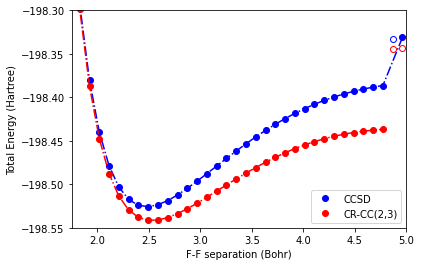

In [43]:
#%matplotlib widget


plt.plot(R[cc_converged], cc_energy[cc_converged], 'bo', label='CCSD')
plt.plot(R[cc_converged], cc_energy[cc_converged], 'b-.')
plt.plot(R[[not x for x in cc_converged]], cc_energy[[not x for x in cc_converged]], 'bo', markerfacecolor='none')

plt.plot(R[crcc_converged], crcc_energy[crcc_converged], 'ro', label='CR-CC(2,3)')
plt.plot(R[crcc_converged], crcc_energy[crcc_converged], 'r-.')
plt.plot(R[[not x for x in crcc_converged]], crcc_energy[[not x for x in crcc_converged]], 'ro', markerfacecolor='none')


plt.xlabel('F-F separation (Bohr)')
plt.ylabel('Total Energy (Hartree)')
plt.ylim([-198.55, -198.3])
plt.xlim([1.75, 5])
plt.legend(loc=4)

plt.show()